In [1]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm_notebook
import pickle

from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

In [2]:
# Dataset import

df = pd.read_csv("Py_Dataset_staz.csv")
df.head()

,Unnamed: 0,Date,Y_log,Rural,Time,NS,quota,Provincia,Zonizzazione,Tipo,id
0,1,2018-01-01,3.688645,1,0,BADIA,0.522332,PR,Pianura Ovest,Fondo,1
1,2,2018-01-02,2.743930,1,1,BADIA,0.522332,PR,Pianura Ovest,Fondo,1
2,3,2018-01-03,2.687557,1,2,BADIA,0.522332,PR,Pianura Ovest,Fondo,1
3,4,2018-01-04,2.850192,1,3,BADIA,0.522332,PR,Pianura Ovest,Fondo,1
4,5,2018-01-05,3.558992,1,4,BADIA,0.522332,PR,Pianura Ovest,Fondo,1


In [3]:
staz = pd.read_csv("Stazioni_Emilia.csv")
staz.head()

,NomeStazione,Lat,Long,Regione,Quota,Provincia,AreaStazione,TipoStazione,id
0,BADIA,44.658309,10.285714,Emilia-Romagna,202.0,PR,Rurale,Fondo,1
1,BESENZONE,44.987113,9.955758,Emilia-Romagna,50.0,PC,Rurale,Fondo,2
2,BOGOLESE,44.835555,10.397238,Emilia-Romagna,35.0,PR,Suburbano,Industriale,3
3,CAORLE,44.418868,12.224176,Emilia-Romagna,4.0,RA,Urbano,Fondo,4
4,CASTELLARANO,44.532199,10.706261,Emilia-Romagna,150.0,RE,Suburbano,Fondo,5


2.3056598969634683

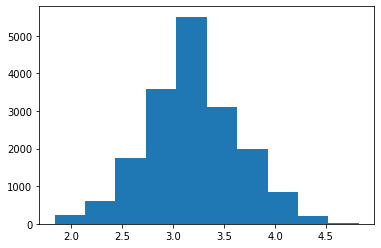

In [4]:
plt.hist(df.Y_log)
np.std(df.Y_log)*5 # a = 2, b = 3 per invgamma

In [5]:
# dummies

dummies = pd.get_dummies(df.Tipo)
dummies.head()

,Fondo,Industriale,Traffico
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


# MODEL INPUT

- N = length(Y) = number of total samples 
- k = number of Fourier basis (2/4/8/12)
- p = 3 = number of regressors {quota + tipo(dummyx2)}


- y {N vector} : PM10 time series
- x {Nxp matrix} : covariates matrix
- t {N vector} : time istant
- r {N vector binary} : 1 if rural, 0 otherwise
- omega = 2$\pi$/365 : annual frequency


# MODEL PARAMETERS

- a {k/2 vector} : sin coefficients
- b {k/2 vector} : cos coefficients
- c {real} : constant term for f(t)


- a_r {k/2 vector} : sin coefficients - rural 
- b_r {k/2 vector} : cos coefficients - rural
- c_r {real} : constant term for fr(t) - rural


- beta {p vector} : covariates coefficients
- sigma_sq {real > 0} : y variance


In [6]:
normal_reg = """
data {
    int<lower=0> N; 
    int<lower=0> k;
    int<lower=0> p;
    int<lower=0> G;
    
    vector[N] Y;
    matrix[N, p] X;
    vector[N] t;
    vector[N] r;
    int stazione[N];
    real omega;
    row_vector[2] coord[G];
}

transformed data {
    int K;
    K = k%/%2;
}

parameters {

    real<lower=0> sigma_sq;
    
    vector[p] beta;
    
    vector[K] a;
    vector[K] b;
    real c;
    
    vector[K] a_r;
    vector[K] b_r;
    real c_r;
    
    vector[G] w;
    real<lower=0> rho;
    real<lower=0> alpha;
}


transformed parameters {
    real<lower=0> sigma;
    sigma = sqrt(sigma_sq);
    
    vector[N] ft;
    ft = to_vector(rep_array(c, N));
    for (j in 1:K){
     ft += a[j]*sin(j*omega*t) + b[j]*cos(j*omega*t);
    }
    
    vector[N] ft_r;
    ft_r = to_vector(rep_array(c_r, N));
    for (j in 1:K){
     ft_r += a_r[j]*sin(j*omega*t) + b_r[j]*cos(j*omega*t);
     }
    
    vector[N] mu;
    mu = rows_dot_product(r, ft_r) + rows_dot_product(1-r, ft) 
         + X*beta ;
    mu[1:N] += w[stazione[1:N]];
         
    cov_matrix[G] H = cov_exp_quad(coord, alpha, rho);
}

model {  

    sigma_sq ~ inv_gamma(2, 3);
    
    beta ~ normal(0, 10);
    
    a ~ normal(0, 10);
    b ~ normal(0, 10);
    c ~ normal(0, 10);
    
    a_r ~ normal(0, 10);
    b_r ~ normal(0, 10);
    c_r ~ normal(0, 10);
    
    w ~ multi_normal(rep_vector(0,G),H);
    
    
    Y ~ normal(mu, sigma);  
}

generated quantities  {
  vector[N] log_lik;
  for (j in 1:N) {
    log_lik[j] = normal_lpdf(Y[j] | mu[j], sigma);
  }
}
"""

stan_file = "./normal_reg.stan"

with open(stan_file, "w") as f:
    print(normal_reg, file=f)

normal_reg = CmdStanModel(stan_file=stan_file)

INFO:cmdstanpy:compiling stan file /mnt/c/Users/franc/Desktop/Bayesian-Statistic/Project/normal_reg.stan to exe file /mnt/c/Users/franc/Desktop/Bayesian-Statistic/Project/normal_reg
INFO:cmdstanpy:compiled model executable: /mnt/c/Users/franc/Desktop/Bayesian-Statistic/Project/normal_reg
--- Translating Stan model to C++ code ---
bin/stanc  --o=/mnt/c/Users/franc/Desktop/Bayesian-Statistic/Project/normal_reg.hpp /mnt/c/Users/franc/Desktop/Bayesian-Statistic/Project/normal_reg.stan
Warning in '/mnt/c/Users/franc/Desktop/Bayesian-Statistic/Project/normal_reg.stan', line 63, column 22: cov_exp_quad is deprecated and will be removed in the future. Use gp_exp_quad_cov instead.

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/

In [7]:
y = np.array(df.Y_log)
x = np.matrix( pd.concat([df.quota, dummies.Fondo, dummies.Industriale], axis=1) )
t = np.array(df.Time)
r = np.array(df.Rural)
stazione = np.array(df.id)
omega = 2*np.pi/365
coord = np.matrix( pd.concat([staz.Lat, staz.Long], axis=1) )

N = len(y)
p = 3   # Quota + Tipo(2 dummies)
k = 2   # 4 basi di fourier + const
G = 49  # numero stazioni in Emilia-Romagna

In [8]:
reg_data = {
    "N": N,   # 18 000 circa (49x365)
    "k": k,   # Fbasis number
    "p": p,   # 3
    "G": G,
    
    "Y": y,
    "X": x, 
    "t": t,
    "r": r,
    "stazione": stazione,
    "omega": omega,
    "coord": coord
}

fit = normal_reg.sample(data=reg_data, chains=2, parallel_chains=2, 
                             iter_warmup=500, iter_sampling=2000, show_progress=True)


INFO:cmdstanpy:CmdStan start procesing
ERROR:cmdstanpy:Error in progress bar initialization:
	"Unknown argument(s): {'colour': 'yellow'}"
Disabling progress bars for this session


INFO:cmdstanpy:CmdStan done processing.


In [6]:
import pickle

# salva la catena con pickle
pickle.dump(fit, open( "save1.p", "wb" ))

NameError: name 'fit' is not defined

In [7]:
#apro la catena con pickle
fit = pickle.load( open( "save1.p", "rb" ) )

#non credo serva a niente (o almeno a noi non serve) il comando .draws_pd 
pd = fit.draws_pd()

In [8]:
normal_az = az.from_cmdstanpy(fit)

In [11]:
type(fit)

cmdstanpy.stanfit.CmdStanMCMC

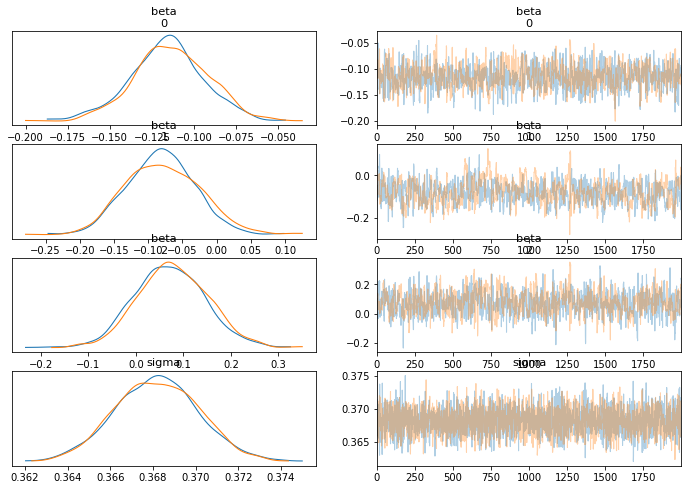

In [12]:
# parameters: beta and sigma
az.plot_trace(normal_az, var_names=["beta", "sigma"], compact=False)
plt.show()

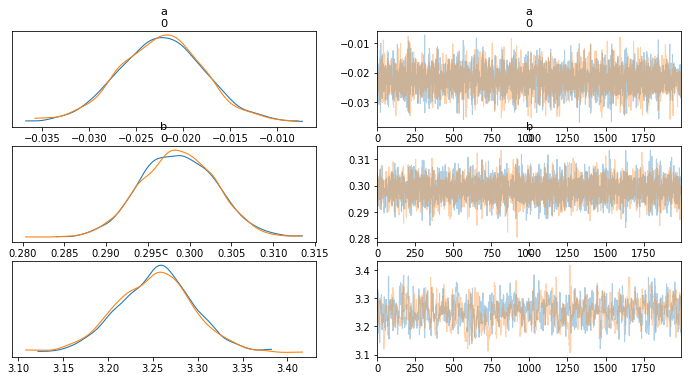

In [13]:
# parameters NON-rural f(t)
az.plot_trace(normal_az, var_names=["a", "b", "c"], compact=False)
plt.show()

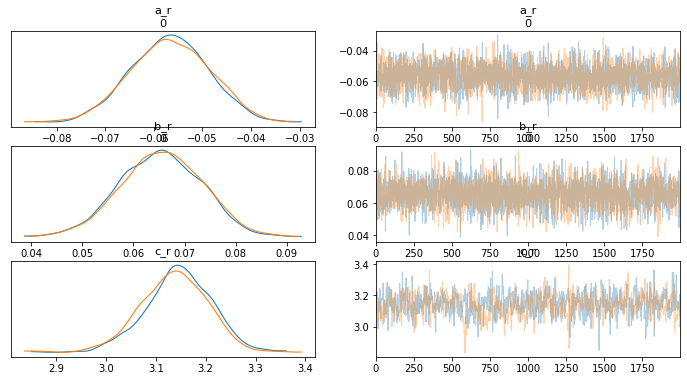

In [14]:
# parameters rural f(t)
az.plot_trace(normal_az, var_names=["a_r", "b_r", "c_r"], compact=False)
plt.show()

/home/francesca/.local/lib/python3.8/site-packages/arviz/plots/traceplot.py:206: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (49), generating only 20 plots
  warnings.warn(


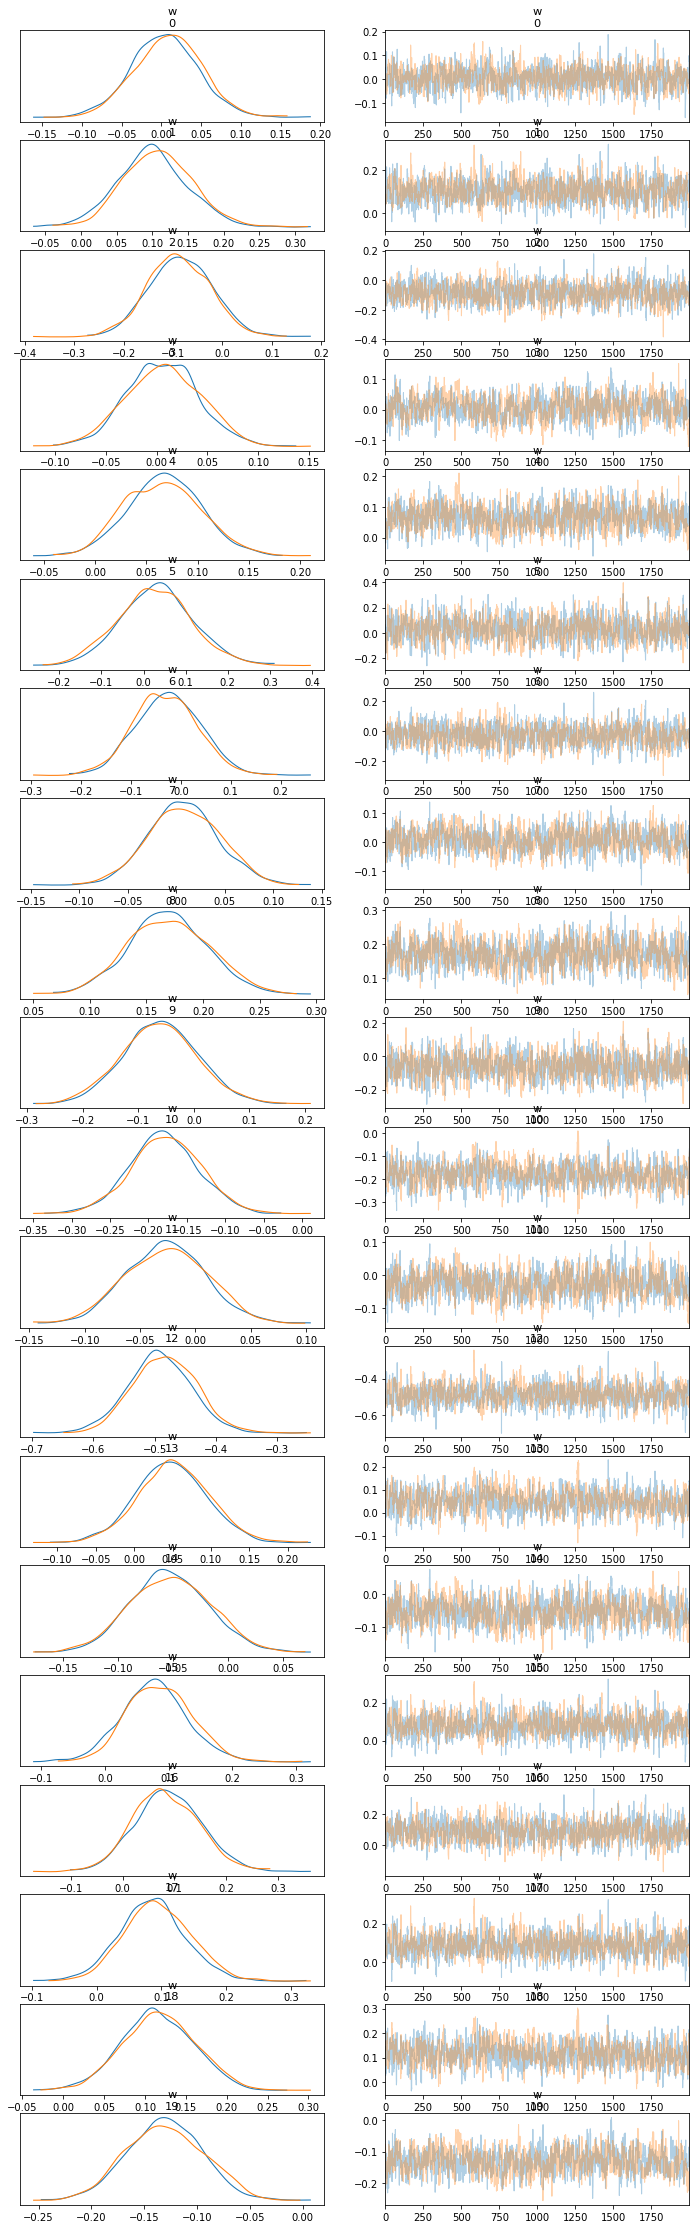

In [16]:
# parameters wi
az.plot_trace(normal_az, var_names=["w"], compact=False)
plt.show()

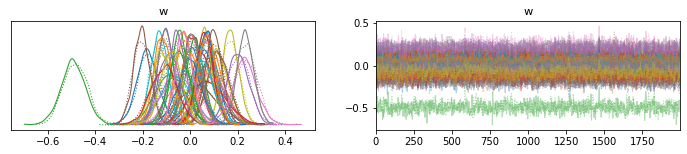

In [17]:
# parameters wi
az.plot_trace(normal_az, var_names=["w"], compact=True)
plt.show()

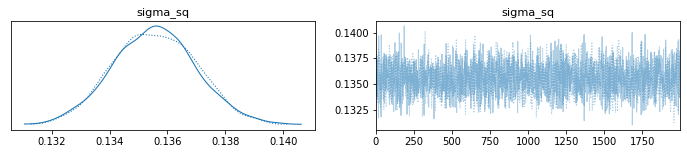

In [15]:
# transformed parameters: sigma^2
az.plot_trace(normal_az, var_names=["sigma_sq"])
plt.show()

In [ ]:
# iterazioni divergenti? Nessuna
np.sum(normal_az.sample_stats.diverging)

In [ ]:
# GOF analysis
print("WAIC: ", az.waic(normal_az, var_name="log_lik"))

In [ ]:
print("LOO: ", az.loo(normal_az, var_name="log_lik"))

In [ ]:
normal_2 = """
data {
    int<lower=0> N; 
    int<lower=0> p;
    
    vector[N] Y;
    matrix[N, p] X;
    vector[N] t;
    vector[N] r;
    real omega;
}


parameters {

    real<lower=0> sigma_sq;
    
    vector[p] beta;
    
    vector[4] a;
    vector[4] b;
    real c;
    
    vector[4] a_r;
    vector[4] b_r;
    real c_r;
}


transformed parameters {
    real<lower=0> sigma;
    sigma = sqrt(sigma_sq);
    
    vector[N] ft;
    ft = to_vector(rep_array(c, N));
    ft = a[1]*sin(omega*t) + b[1]*cos(omega*t) 
         + a[2]*sin(6*omega*t) + b[2]*cos(6*omega*t)
         + a[3]*sin(12*omega*t) + b[3]*cos(12*omega*t)
         + a[4]*sin(52*omega*t) + b[4]*cos(52*omega*t);
    
    
    vector[N] ft_r;
    ft_r = to_vector(rep_array(c_r, N));
    ft_r += a_r[1]*sin(omega*t) + b_r[1]*cos(omega*t) 
            + a_r[2]*sin(6*omega*t) + b_r[2]*cos(6*omega*t) 
            + a_r[3]*sin(12*omega*t) + b_r[3]*cos(12*omega*t)
            + a_r[4]*sin(52*omega*t) + b_r[4]*cos(52*omega*t);
    
    
    vector[N] mu;
    mu = rows_dot_product(r, ft_r) + rows_dot_product(1-r, ft) 
         + X*beta;
}

model {  

    sigma_sq ~ inv_gamma(2, 3);
    
    beta ~ normal(0, 10);
    
    a ~ normal(0, 10);
    b ~ normal(0, 10);
    c ~ normal(0, 10);
    
    a_r ~ normal(0, 10);
    b_r ~ normal(0, 10);
    c_r ~ normal(0, 10);
    
    
    Y ~ normal(mu, sigma);  
}

generated quantities  {
  vector[N] log_lik;
  for (j in 1:N) {
    log_lik[j] = normal_lpdf(Y[j] | mu[j], sigma);
  }
}
"""

stan_file = "./normal_2.stan"

with open(stan_file, "w") as f:
    print(normal_2, file=f)

normal_2 = CmdStanModel(stan_file=stan_file)

In [ ]:
reg_data = {
    "N": N,   # 18 000 circa (49x365)
    "p": p,   # 3
    
    "Y": y,
    "X": x, 
    "t": t,
    "r": r,   
    "omega": omega
}

fit = normal_2.sample(data=reg_data, chains=3, parallel_chains=3, 
                             iter_warmup=700, iter_sampling=2300, show_progress=True)

In [ ]:
normal_az_2 = az.from_cmdstanpy(fit)

In [ ]:
# parameters: beta and sigma
az.plot_trace(normal_az_2, var_names=["beta", "sigma"], compact=False)
plt.show()

In [ ]:
# parameters NON-rural f(t)
az.plot_trace(normal_az_2, var_names=["a", "b", "c"], compact=False)
plt.show()

In [ ]:
# parameters rural f(t)
az.plot_trace(normal_az_2, var_names=["a_r", "b_r", "c_r"], compact=False)
plt.show()

In [ ]:
# per scegliere modello migliore
# az.compare({"model_1": normal_az, "model_2": modello_new})